# Prepare and Run OpenMM Simulation

This notebook allows you to run an OpenMM simulation locally or on a job submission cluster, like Wynton.

You may run this notebook top-to-bottom, except where you see cells titled **OPTION**. These indicate places you may choose to run certain code (e.g. running a simulation in the jupyter notebook vs on a cluster).

In [105]:
import os
import sys
import requests
from pathlib import Path
from tqdm import tqdm

import openmm
from openmm import unit as openmm_unit
from openmm.app import PDBFile

from openff.units import Quantity, unit
from openff.toolkit import ForceField, Molecule, Topology

import nglview as nv
import mdtraj as md
from pdbfixer import PDBFixer

from rdkit import Chem

from matplotlib import pyplot as plt
import numpy as np

# from openmm import *
# from openmm.app import *
# from openmm.unit import *
# import nglview as nv
# import mdtraj as md
# from matplotlib import pyplot as plt
# from pdbfixer import PDBFixer

# Load Starting Structure

### OPTION 1) Load local file

In [3]:
### Using local file? ###
input_pdb_file = '5RGA.pdb'

### OPTION 2) Load from PDB

In [3]:
### Or, using PDB ID? ###
input_pdb_ID = '5RGA'

def download_pdb(pdb_id):
    url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
    response = requests.get(url)
    
    if response.status_code == 200:
        with open(f'{pdb_id}.pdb', 'w') as file:
            file.write(response.text)
        print(f'Successfully downloaded {pdb_id}.pdb')
    else:
        print(f'Failed to download {pdb_id}.pdb. Please check the PDB ID.')

download_pdb(input_pdb_ID)
input_pdb_file = f'{input_pdb_ID}.pdb'

Successfully downloaded 5RGA.pdb


# Prepare Simulation

In [4]:
experiment_name = '1_31_2024/ligand_testing/HG3.0_apo'
#experiment_name = '1AKI_test_1'

step_size           = 0.002             # picoseconds
temperature         = 300               # kelvin

forcefield_files = ['charmm36.xml', 'charmm36/water.xml']
#forcefield_files = ['amber99sbildn.xml', 'amber99_obc.xml']

##########################################
############ DIRECTORY SETUP #############
##########################################
# experiments/
#     new_experiment/
#         inputs/
#             raw/
#             processed/
#         simulations/
#     another_experiment/...
experiments_dir = Path('experiments')
current_experiment_dir = experiments_dir / experiment_name
inputs_dir = current_experiment_dir / 'inputs'
raw_dir = inputs_dir / 'raw'
processed_dir = inputs_dir / 'processed'
sim_dir = current_experiment_dir / 'simulations'

#Make the directories if they don't exist
dir_list = [experiments_dir, current_experiment_dir, inputs_dir, raw_dir, processed_dir, sim_dir]
for dir in dir_list:
    if not dir.exists():
        #make directory recursively:
        dir.mkdir(parents=True)

#Let's copy the input files to the inputs:
os.system('cp ' + input_pdb_file + ' ' + str(raw_dir))
pdb_path = raw_dir / Path(input_pdb_file).name

#show with nglview
view = nv.show_file(str(pdb_path))
view.add_representation('ball+stick', selection='all')
#show heteroatoms larger:
view.add_representation('ball+stick', selection='hetero', aspectRatio=4.0)
view._set_size('1600px', '800px')
view

NGLWidget()

In [40]:
#show with nglview
view = nv.show_file(str(pdb_path))
view.add_representation('ball+stick', selection='6NT')
view._set_size('1600px', '800px')
view

NGLWidget()

### Take care during processing!
In this step, we make decisions for processing our pdb before the simulation. Here you may think about the following options, and enable or disable in the code below:
- Do you want to keep certain heteroatoms?
- Do you want to keep all chains, or just one?
- Do you want PDBfixer to add missing residues?

In [97]:
############################################
############ PROCESS INPUT PDB #############
############################################

# are we using a ligand?
is_ligand = True                # set to True if there is a ligand
ligand_residue_idx = 401

#which chain are we keeping?
chain_to_keep = 0               # 0-indexed, and it's a number, not a letter!

standard_aa = ['ALA', 'CYS', 'ASP', 'GLU', 'PHE', 'GLY', 'HIS', 'ILE', 'LYS', 'LEU', 
               'MET', 'ASN', 'PRO', 'GLN', 'ARG', 'SER', 'THR', 'VAL', 'TRP', 'TYR' ]

### Create PDBFixer object
pdb = PDBFixer(str(pdb_path))

### Fix messed up residues
pdb.findMissingResidues()
#pdb.findNonstandardResidues()
#pdb.replaceNonstandardResidues() 
pdb.findMissingAtoms()
pdb.addMissingAtoms()    #this adds both missing atoms and residues

#delete all chains, aside from the first one:
chains_to_delete = [chain.index for chain in pdb.topology.chains() if chain.index != chain_to_keep]
pdb.removeChains(chains_to_delete)

# delete heteroatoms and water: (don't worry, we'll add the ligand back later!)
pdb.removeHeterogens(keepWater=False)

#add hydrogens:
pdb.addMissingHydrogens(7.0)

#solvate in a water box:
pdb.addSolvent(padding=10*openmm_unit.angstroms)

# write out the processed pdb
print('Writing out the processed input pdb...')
PDBFile.writeFile(pdb.topology, pdb.positions, str(processed_dir / Path(input_pdb_file).name))

#show with nglview
view = nv.show_file(str(processed_dir / Path(input_pdb_file).name))
view.add_representation('ball+stick', selection="all and not water")
view.add_representation('ball+stick', selection='water', opacity=0.1)
view._set_size('1600px', '800px')
view



Writing out the processed input pdb...


NGLWidget()

In [98]:
def create_ligand_topology(pdb, ligand_residue_idx):
    #First, find the ligand:
    ligand = None
    ligand_name = None
    for residue in pdb.topology.residues():
        if int(residue.id) == ligand_residue_idx:   #note: residue.index is NOT the same as residue.id!
            ligand = residue
            ligand_name = residue.name
            break
    if ligand is None:
        raise ValueError(f'Could not find ligand with residue index {ligand_residue_idx}')
    print(f'Found ligand: {ligand.name} with {len(list(ligand.atoms()))} atoms')

    #create a new topology object:
    ligand_topology = openmm.app.Topology()

    #add all atoms to a new residue and chain:
    ligand_chain = ligand_topology.addChain()
    ligand_residue = ligand_topology.addResidue(ligand.name, ligand_chain)
    [ligand_topology.addAtom(atom.name, atom.element, ligand_residue) for atom in ligand.atoms()]

    #get positions from ligand.atoms():
    ligand_positions = [pdb.positions[atom.index] for atom in ligand.atoms()]
    ligand_positions = [pos.value_in_unit(openmm_unit.angstroms) for pos in ligand_positions]

    return ligand_topology, ligand_positions, ligand_name

def download_ligand_sdf(three_letter_code, file_path):
    url = f'https://files.rcsb.org/ligands/download/{three_letter_code}_ideal.sdf'
    response = requests.get(url)
    
    if response.status_code == 200:
        with open(file_path, 'w') as file:
            file.write(response.text)
        print(f"SDF file for {three_letter_code} downloaded successfully.")
    else:
        print(f"Failed to download SDF file. HTTP status code: {response.status_code}")

#extract the ligand to it's own PDB:
if is_ligand:

    #############################################
    ############ EXTRACT LIGAND #################
    #############################################

    try:
        #Let's take the original pdb file, once again:
        original_pdb = PDBFixer(str(pdb_path))
        
        #get the ligand topology and positions:
        ligand_topology, ligand_positions, ligand_code = create_ligand_topology(original_pdb, ligand_residue_idx)

        #write the ligand to a new PDB file:
        ligand_path_pdb = processed_dir / f'{input_pdb_file[:-4]}_ligand.pdb'
        PDBFile.writeFile(ligand_topology, ligand_positions, str(ligand_path_pdb))

        #Then, write to SDF file, making sure to keep hydrogens:
        ligand_mol = Chem.MolFromPDBFile(str(ligand_path_pdb), removeHs=False)
        ligand_path = processed_dir / f'{input_pdb_file[:-4]}_ligand.sdf'
        writer = Chem.SDWriter(str(ligand_path))
        writer.write(ligand_mol)
        writer.close()
    except:
        print('Failed to extract ligand:', sys.exc_info()[0])

    #############################################
    ############# FIX BOND ORDERS ###############
    #############################################
    ligand_template_path = processed_dir / f'{input_pdb_file[:-4]}_ligand_template.sdf'  # Replace with your desired file path
    download_ligand_sdf(ligand_code, ligand_template_path)
    
    extracted_ligand = Chem.MolFromMolFile(str(ligand_path), removeHs=False)
    template_ligand = Chem.MolFromMolFile(str(ligand_template_path), removeHs=False)

    # Check if the number of atoms match in both molecules
    if extracted_ligand.GetNumAtoms() != template_ligand.GetNumAtoms():
        raise ValueError("The number of atoms in the extracted ligand and template ligand do not match. \
                        \n Does your template ligand have the same number of hydrogens?")

    # Update the coordinates of the template ligand with those from the extracted ligand
    template_conf = template_ligand.GetConformer()
    extracted_conf = extracted_ligand.GetConformer()

    for i in range(extracted_ligand.GetNumAtoms()):
        pos = extracted_conf.GetAtomPosition(i)
        template_conf.SetAtomPosition(i, pos)
    # Save the updated ligand
    ligand_path_updated = processed_dir / f'{input_pdb_file[:-4]}_ligand_updated.sdf'
    Chem.MolToMolFile(template_ligand, str(ligand_path_updated))

    print("Updated ligand saved to", str(ligand_path_updated))

    #############################################
    ########### SAVE AND VISUALIZE ##############
    #############################################
    
    # Load a molecule from a SDF file
    ligand = Molecule.from_file(ligand_path_updated)
    # Print out a SMILES code for the ligand
    print(ligand.to_smiles(explicit_hydrogens=False))
    # Visualize the molecule
    ligand.visualize(show_all_hydrogens=False)


Found ligand: 6NT with 16 atoms
SDF file for 6NT downloaded successfully.
Updated ligand saved to experiments/1_31_2024/ligand_testing/HG3.0_apo/inputs/processed/5RGA_ligand_updated.sdf
O=[N+]([O-])c1ccc2nn[nH]c2c1


In [106]:
#Pulled directly from https://github.com/openforcefield/openff-toolkit/blob/stable/examples/toolkit_showcase/toolkit_showcase.ipynb
def insert_molecule_and_remove_clashes(
    topology: Topology,
    insert: Molecule,
    radius: Quantity = 1.5 * unit.angstrom,
    keep: list[Molecule] = [],
) -> Topology:
    """
    Add a molecule to a copy of the topology, removing any clashing molecules.

    The molecule will be added to the end of the topology. A new topology is
    returned; the input topology will not be altered. All molecules that
    clash will be removed, and each removed molecule will be printed to stdout.
    Users are responsible for ensuring that no important molecules have been
    removed; the clash radius may be modified accordingly.

    Parameters
    ==========
    top
        The topology to insert a molecule into
    insert
        The molecule to insert
    radius
        Any atom within this distance of any atom in the insert is considered
        clashing.
    keep
        Keep copies of these molecules, even if they're clashing
    """
    # We'll collect the molecules for the output topology into a list
    new_top_mols = []
    # A molecule's positions in a topology are stored as its zeroth conformer
    insert_coordinates = insert.conformers[0][:, None, :]
    for molecule in tqdm(topology.molecules):
        if any(keep_mol.is_isomorphic_with(molecule) for keep_mol in keep):
            new_top_mols.append(molecule)
            continue
        molecule_coordinates = molecule.conformers[0][None, :, :]
        diff_matrix = molecule_coordinates - insert_coordinates

        # np.linalg.norm doesn't work on Pint quantities 😢
        working_unit = unit.nanometer
        distance_matrix = (
            np.linalg.norm(diff_matrix.m_as(working_unit), axis=-1) * working_unit
        )
        if distance_matrix.min() > radius:
            # This molecule is not clashing, so add it to the topology
            new_top_mols.append(molecule)
        else:
            print(f"Removed {molecule.to_smiles()} molecule")

    # Insert the ligand at the end
    new_top_mols.append(ligand)

    # This pattern of assembling a topology from a list of molecules
    # ends up being much more efficient than adding each molecule
    # to a new topology one at a time
    new_top = Topology.from_molecules(new_top_mols)

    # Don't forget the box vectors!
    new_top.box_vectors = topology.box_vectors
    return new_top

#Let's get the topology of the processed PDB. This may take several minutes...
top = Topology.from_pdb(processed_dir / Path(input_pdb_file).name)

print('Inserting ligand and removing clashes...')
top = insert_molecule_and_remove_clashes(top, ligand)

Inserting ligand and removing clashes...


0it [00:00, ?it/s]

74564it [00:23, 3185.01it/s]


In [107]:
def visualize(topology):
    """Visualize a topology with nglview"""
    from io import StringIO

    with StringIO() as f:
        topology.to_file(file=f)
        pdb_str = f.getvalue()
    return nv.show_text(pdb_str)

# Create the widget. By default, proteins are shown as a cartoon and unrecognised ligands with a ball-and-stick model
view = visualize(top)
view.add_line(selection="(not protein and not water)")
view.add_representation('cartoon', selection='protein', opacity=0.1)
# Make the ions clearer by drawing their vdW surfaces
view.add_spacefill(selection=":.NA or :.CL")

# Render the widget
view


NGLWidget()

# Parameterize Everything

In [110]:
### WARNING: the combination of SAGE and ff14SB has not been fully tested.
### I will continue looking for the best way to combine OpenFF with something like CHARMM36.
sage_ff14sb = ForceField("openff-2.0.0.offxml", "ff14sb_off_impropers_0.0.3.offxml")

In [111]:
#This took 40 minutes to run, for a system of 230K atoms. (I cry.)
print('Creating OpenFF Interchange...')
interchange = sage_ff14sb.create_interchange(top)

print('Converting to OpenMM System...')
omm_system = interchange.to_openmm()
omm_top = interchange.to_openmm_topology()

Creating OpenFF Interchange...
Converting to OpenMM System...


In [6]:
#print number of atoms:
print('Number of atoms:')
print(modeller.topology.getNumAtoms())

Number of atoms:
23622


# Run Simulation

In [114]:
############################################
############# SIM PARAMETERS ###############
############################################

minimization_steps  = 0     # 0 means run until convergence, recommended.
equilibration_steps = 10000

# 500000 = 1 ns. On a 4080TI, this takes around 2 minutes for a small system (20K atoms).
production_steps    = 500000 * 10

reporting_interval = 5000

### OPTION 1) Run Locally
This will run in the notebook. If you stop the notebook or kill your connection, the simulation will stop.

In [8]:
############################################
############ CREATE SIMULATION #############
############################################

############################################
############ RUN MINIMIZATION ##############
############################################
print('Minimizing energy...')
simulation.minimizeEnergy(maxIterations=minimization_steps)

# write out the minimized pdb
print('Writing out the minimized pdb...')
PDBFile.writeFile(simulation.topology, simulation.context.getState(getPositions=True).getPositions(), str(sim_dir / (str(Path(input_pdb_file).stem) + '_minim.pdb')))

############################################
############ RUN EQUILIBRATION #############
############################################
print('Running equilibration...')
simulation.context.setVelocitiesToTemperature(temperature)
simulation.reporters.append(DCDReporter(sim_dir / (str(Path(input_pdb_file).stem) + '_equil.dcd'), reporting_interval))
simulation.reporters.append(StateDataReporter(sys.stdout, 1000, step=True, potentialEnergy=True, temperature=True))
simulation.step(equilibration_steps)

############################################
############ RUN PRODUCTION ################
############################################
print('Running production...')
simulation.reporters.clear()
simulation.reporters.append(DCDReporter(sim_dir / (str(Path(input_pdb_file).stem) + '_prod.dcd'), reporting_interval))
simulation.reporters.append(StateDataReporter(sys.stdout, reporting_interval, step=True, potentialEnergy=True, temperature=True))
simulation.step(production_steps)

print('Done!')


Minimizing energy...
Writing out the minimized pdb...
Running equilibration...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,-3197098.5342291165,266.66524486102634
2000,-3093044.0342291165,289.3386032296135
3000,-3064020.0225103665,297.52257084330137
4000,-3052735.3037603665,300.12187001274884
5000,-3051218.8857916165,300.66524012860225
6000,-3050394.3662603665,300.7743003774468
7000,-3049311.2842291165,299.5560027876655
8000,-3051936.6709478665,300.63183680843815
9000,-3052963.6982916165,299.5042339590963
10000,-3051326.7725103665,300.20284897274263
Running production...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
15000,-3049843.1943853665,299.95509466251434
20000,-3050124.1279791165,299.4702365465223
25000,-3049730.3701666165,299.7713384601881
30000,-3048356.4990728665,300.78585281662316
35000,-3052267.4092291165,299.92569506896615
40000,-3050678.5576666165,299.10973237390255
45000,-3049534.1787603665,299.8168345299463
50000,-3051810.1396978665,299.9125132688

### OPTION 2) Submit it to a queue via SLURM

In [64]:
### arguments for bash script:
simulation_dict =   {'minimization_steps': minimization_steps,
                        'equilibration_steps': equilibration_steps,
                        'production_steps': production_steps,
                        'reporting_interval': reporting_interval,
                        'input_pdb_file': input_pdb_file,
                        'sim_dir': str(sim_dir),
                        'processed_dir': str(processed_dir),
                        'experiment_name': experiment_name,
                        'forcefield_files': forcefield_files,
                        'step_size': step_size,
                        'temperature': temperature,
                        'only_production': False}       #this is a flag to only run production, for when we want to continue a simulation

#save it as a json:
import json
with open(current_experiment_dir / 'simulation_parameters.json', 'w') as file:
    json.dump(simulation_dict, file)

#now, let's write a bash script to run the simulation, that takes the path to the parameter file as an argument
bash_script = f'''#!/bin/bash
#SBATCH --job-name={experiment_name.replace('/', '_')}
#SBATCH --output={experiment_name.replace('/', '_')}.out
#SBATCH --error={experiment_name.replace('/', '_')}.err
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=4
#SBATCH --mem-per-cpu=8gb
#SBATCH --time=1-00:00:00

source ~/.bashrc
conda activate openmm

python3 ./batch/run_batch_sim.py {current_experiment_dir / 'simulation_parameters.json'}
'''

with open(current_experiment_dir / 'run_simulation.sh', 'w') as file:
    file.write(bash_script)


#Finally, let's queue the job:
os.system('sbatch ' + str(current_experiment_dir / 'run_simulation.sh'))
print('Job queued!')

Submitted batch job 12
Job queued!


In [7]:
#Notes for converting for SGE on Wynton:
#2 hour cap on the GPU nodes.
#From jonathan's data, can safely assume we get ~200 ns/day (often much more) for ~60K atoms, which is 8.3 ns/hour.
#For a 2 hour job, we can safely assume we get 16 ns of simulation time.
# ns_per_2_hr = 120 / (7/(3.6*10**9) * num_atoms**2 )
# take this number, get the total steps per sim. Then, feed this into Fiona's script to batch sequential jobs on Wynton.

'''#!/bin/bash           # the shell language when run outside of the job scheduler
#                     # lines starting with #$ is an instruction to the job scheduler
#$ -S /bin/bash       # the shell language when run via the job scheduler [IMPORTANT]
#$ -cwd               # job should run in the current working directory
#$ -j y               # STDERR and STDOUT should be joined
#$ -l mem_free=1G     # job requires up to 1 GiB of RAM per slot
#$ -l scratch=2G      # job requires up to 2 GiB of local /scratch space
#$ -l h_rt=24:00:00   # job requires up to 24 hours of runtime
##$ -t 1-10           # array job with 10 tasks (remove first '#' to enable)
#$ -r y               # if job crashes, it should be restarted

## If you array jobs (option -t), this script will run T times, once per task.
## For each run, $SGE_TASK_ID is set to the corresponding task index (here 1-10).
## To configure different parameters for each task index, one can use a Bash 
## array to map from the task index to a parameter string.

## All possible parameters
# params=(1bac 2xyz 3ijk 4abc 5def 6ghi 7jkl 8mno 9pqr 10stu)

## Select the parameter for the current task index
## Arrays are indexed from 0, so we subtract one from the task index
# param="${params[$((SGE_TASK_ID - 1))]}"

date
hostname

## End-of-job summary, if running as a job
[[ -n "$JOB_ID" ]] && qstat -j "$JOB_ID"  # This is useful for debugging and usage purposes,
                                          # e.g. "did my job exceed its memory request?"
''' 

'#!/bin/bash           # the shell language when run outside of the job scheduler\n#                     # lines starting with #$ is an instruction to the job scheduler\n#$ -S /bin/bash       # the shell language when run via the job scheduler [IMPORTANT]\n#$ -cwd               # job should run in the current working directory\n#$ -j y               # STDERR and STDOUT should be joined\n#$ -l mem_free=1G     # job requires up to 1 GiB of RAM per slot\n#$ -l scratch=2G      # job requires up to 2 GiB of local /scratch space\n#$ -l h_rt=24:00:00   # job requires up to 24 hours of runtime\n##$ -t 1-10           # array job with 10 tasks (remove first \'#\' to enable)\n#$ -r y               # if job crashes, it should be restarted\n\n## If you array jobs (option -t), this script will run T times, once per task.\n## For each run, $SGE_TASK_ID is set to the corresponding task index (here 1-10).\n## To configure different parameters for each task index, one can use a Bash \n## array to map fr

# View Trajectory

Already ran a sim, and just want to do the analysis?

No need to run the rest of the notebook. Just run the import cell, the relevant cell from [Load Starting Structure](#load-starting-structure), and the first cell from [Prepare Simulation](#prepare-simulation) before continuing on.

In [20]:
# #show the trajectory from PDB with nglview
# traj = md.load(
#     str(sim_dir / (str(Path(input_pdb_file).stem) + '_prod.dcd')), 
#     top=md.Topology.from_openmm(simulation.topology)
# )

traj = md.load(
    str(sim_dir / (str(Path(input_pdb_file).stem) + '_prod.dcd')),
    top = str(processed_dir / Path(input_pdb_file).name)            #get topology from processed pdb
)

#center the trajectory around the protein (to stop periodic boundary artifacts)
protein = traj.topology.guess_anchor_molecules()
centered_traj = traj.image_molecules(anchor_molecules=protein)

#first let's make copy of trajectory without water:
traj_no_water = centered_traj.atom_slice(centered_traj.topology.select('not water'))

view = nv.show_mdtraj(traj_no_water)
view.add_representation('cartoon', selection="protein")
view._set_size('1600px', '800px')
#view.add_representation('ball+stick', selection='water', opacity=0.1)
view

NGLWidget(max_frame=999)

# Analysis

In [23]:
#reporting interval = 5000 steps, step size = 0.002 ps
traj_no_water.time * reporting_interval * step_size

NameError: name 'reporting_interval' is not defined

Text(0, 0.5, 'Distance (Angstroms)')

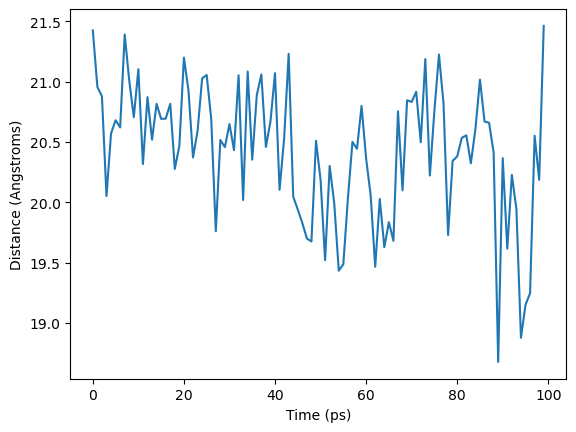

In [12]:
#plot distance between two residues over time:
residue_idx_1 = 1
residue_idx_2 = 120
#get atom indices for the alpha carbons of the residues:
atom_pair = [traj_no_water.topology.select('resid ' + str(residue_idx_1) + ' and name CA')[0], traj_no_water.topology.select('resid ' + str(residue_idx_2) + ' and name CA')[0]]
plt.plot(traj_no_water.time, md.compute_distances(traj_no_water, atom_pairs=[atom_pair])*10) #*10 to convert to angstroms
plt.xlabel('Time (ps)')
plt.ylabel('Distance (Angstroms)')

In [13]:
#show distance between two residues over time with nglview:
view = nv.show_mdtraj(traj_no_water)
view.add_representation('cartoon', selection="all and not water")
view.add_distance(atom_pair=[atom_pair], label_color="black", label=True, color='yellow', label_size=7.5)
view

NGLWidget(max_frame=99)

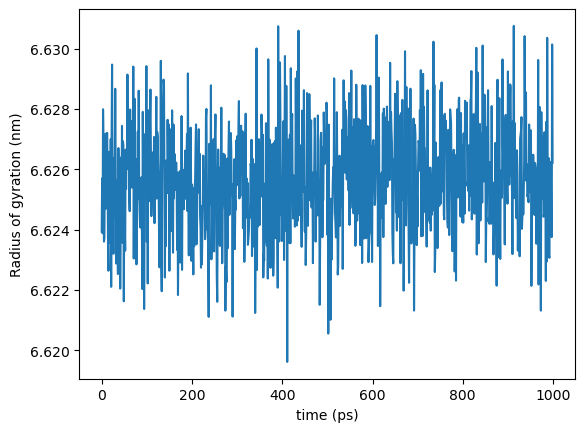

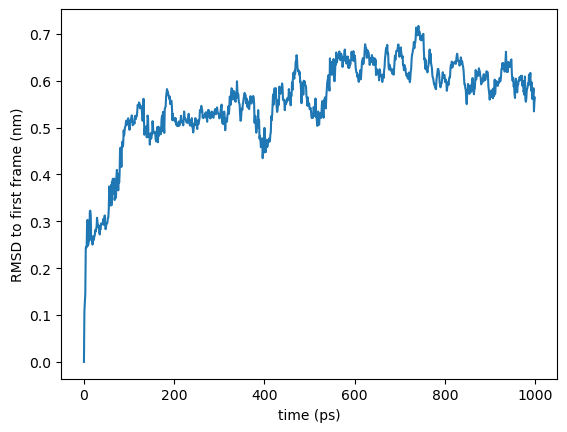

In [19]:
# Radius of gyration over time:
rgyr = md.compute_rg(centered_traj)

# RMSD to the first frame over time:
rmsd_to_first = md.rmsd(traj_no_water, traj_no_water, 0)

# plot them:
plt.plot(traj_no_water.time, rgyr)
plt.xlabel('time (ps)')
plt.ylabel('Radius of gyration (nm)')
plt.show()

plt.plot(traj_no_water.time,  rmsd_to_first, )
plt.xlabel('time (ps)')
plt.ylabel('RMSD to first frame (nm)')
plt.show()



In [1]:
#idea for analysis: take the final 9ns, get the RMSF of the protein, and then plot the RMSF of each residue over time.
#then, show the structure where the color of each residue is the RMSF of that residue over time.
print(traj_no_water.time)
#traj_no_water_9ns = traj_no_water.atom_slice(traj_no_water.time > 41.0) #41.0 is 9ns in ps

NameError: name 'traj_no_water' is not defined

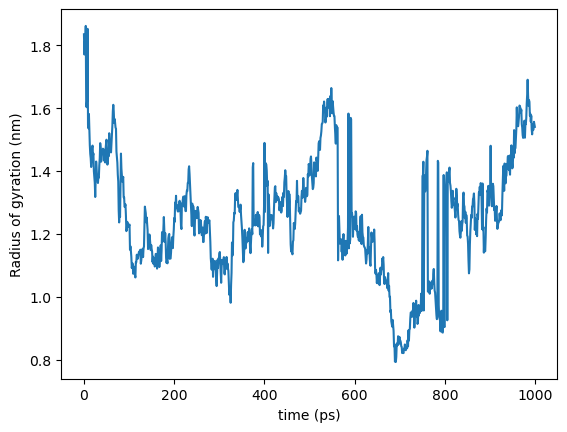

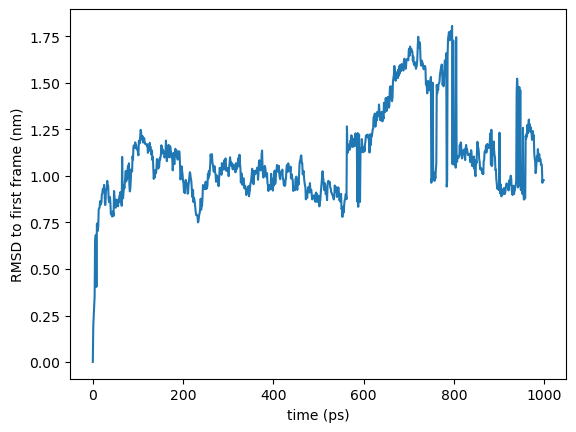

In [21]:
#radius of gyration of only IDR residues (304-318):
rgyr_idr = md.compute_rg(centered_traj.atom_slice(centered_traj.topology.select('resid 304 to 318')))

#rmsd to first frame of only IDR residues (304-318):
rmsd_to_first_idr = md.rmsd(centered_traj.atom_slice(centered_traj.topology.select('resid 304 to 318')), centered_traj.atom_slice(centered_traj.topology.select('resid 304 to 318')), 0)

# plot them:
plt.plot(traj_no_water.time, rgyr_idr)
plt.xlabel('time (ps)')
plt.ylabel('Radius of gyration (nm)')
plt.show()

plt.plot(traj_no_water.time,  rmsd_to_first_idr, )
plt.xlabel('time (ps)')
plt.ylabel('RMSD to first frame (nm)')
plt.show()

In [15]:
# Solvent accessible surface area all residues, using shrake_rupley:
# sasa is a numpy array of shape (n_frames, n_atoms)
sasa = md.shrake_rupley(traj_no_water, probe_radius=0.14, mode='residue')

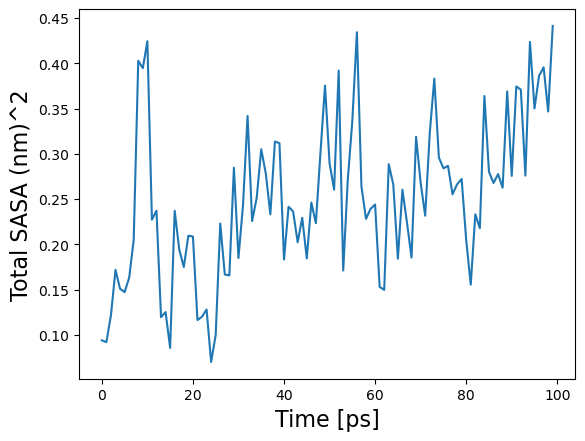

In [16]:
#What's the SASA of residue 108 (TRP)?
residue_idx = 108 #in 1-indexed notation

plt.plot(traj_no_water.time, sasa[:, residue_idx-1])
plt.xlabel('Time [ps]', size=16)
plt.ylabel('Total SASA (nm)^2', size=16)
plt.show()


In [17]:
#show traj with NGLview, highlighting TRP108:
view = nv.show_mdtraj(traj_no_water)
view.add_representation('surface', selection="all")
view.add_representation('surface', selection=str(residue_idx), color='blue')
view

NGLWidget(max_frame=99)

# Notes:
this tutorial contains more suggestions on important things to model (for example, cysteins forming disulfide bridges):
https://mmb.irbbarcelona.org/biobb/workflows/tutorials/amber_md_setup_lig